In [1]:
import json
from glob import glob
import pandas as pd
import seaborn as sb

In [2]:
def f():
    with open('../parliaments/parliament47.json', 'r', encoding='utf-8') as f:
        parliament = json.load(f)
    mapping = {x['_id']: x['name'] for x in parliament['parlGroups']}
    return mapping

# Mapping between political party's ID and name.
mapping = f()

In [3]:
def g(x):
    ans = []
    for session_vote in x['sessionVotes']:
        if session_vote['voteType'] == 'registration':
            continue
        for summary in session_vote['summary']:
            for vote in summary['votes']:
                ans.append({
                    'vote_id': session_vote['_id'],
                    'vote_name': session_vote['name'],
                    'parlGroup': summary['parlGroup'],
                    'decision': vote['decision'],
                    'count': vote['count'],
                })
    return ans


def f():
    xs = []
    for fn in glob('../sessions/*.json'):
        with open(fn, 'r', encoding='utf-8') as f:
            x = json.load(f)
            if not x:
                continue
            xs.extend(g(x))
    return pd.DataFrame(xs)

# Votes per session.
xs = f()
xs['parlGroup_name'] = xs['parlGroup'].map(mapping)

In [4]:
# Normalize voting percentages.
xs['normalized'] = xs['decision'].map({
    'no-vote': 0,      # не гласувал
    'yes': 1,          # да
    'abstain': 0,      # въздържал се
    'no': -1,          # не
    'not-present': 0,  # registration: отсъстващ
    'present': 0,      # registration: регистриран
    'r-present': 0,    # registration: ръчно регистриран
}).mul(xs['count'])

In [5]:
# Group by vote and party.
grouped = xs.groupby(['vote_id', 'parlGroup_name'])
stacked = grouped['normalized'].sum().div(grouped['count'].sum())
votes = stacked.unstack()

In [6]:
# What we have now:
#
# https://www.strazha.bg/sessions/2021-12-08/votes/2
#
# is now turned into:
#
# | Партия          |      Вот |
# |-----------------+----------|
# | БСП за България | 88.4615% |
# | Възраждане      |     100% |
# | ГЕРБ–СДС        | 93.2203% |
# | ДПС             | 73.5294% |
# | ДБ              |   93.75% |
# | ИТН             |      96% |
# | Независими      |        – |
# | ПП              | 94.0299% |
#
# where each value represents what percentage of the parliament group
# voted and how.  Here's a few examples:
#   *  100% means all of the party voted YES
#   * -100% means all of the party voted  NO
#   *    0% means half of the party voted YES, half voted NO, or
#           all the party abstained from voting
#   *   90% may mean 95% voted YES and  5%, or
#                    90% voted YES and 10% abstained
#
# We're going to compute the Pearson correlation on top of these
# values on per-vote basis.
votes[votes.index == '61b9e4f11135732150748e35']

parlGroup_name,БСП за България,Възраждане,ГЕРБ-СДС,Движение за права и свободи,Демократична България,Има такъв народ,Независими,Продължаваме промяната
vote_id,,,,,,,,
61b9e4f11135732150748e35,0.884615,1.0,0.932203,0.735294,0.9375,0.96,NaN,0.940299


In [7]:
corr = votes.corr()
corr.index.rename('', inplace=True)
corr.columns.rename('Парламентарна група', inplace=True)

In [8]:
corr

Парламентарна група,БСП за България,Възраждане,ГЕРБ-СДС,Движение за права и свободи,Демократична България,Има такъв народ,Независими,Продължаваме промяната
,,,,,,,,
БСП за България,1.000000,-0.142250,-0.454466,-0.340105,0.831658,0.694354,0.761880,0.890474
Възраждане,-0.142250,1.000000,0.303498,0.323492,-0.177065,-0.032194,-0.154133,-0.182380
ГЕРБ-СДС,-0.454466,0.303498,1.000000,0.700253,-0.419986,-0.222931,-0.351635,-0.448299
Движение за права и свободи,-0.340105,0.323492,0.700253,1.000000,-0.314888,-0.114960,-0.371374,-0.337062
Демократична България,0.831658,-0.177065,-0.419986,-0.314888,1.000000,0.696627,0.767493,0.898064
Има такъв народ,0.694354,-0.032194,-0.222931,-0.114960,0.696627,1.000000,0.287998,0.729022
Независими,0.761880,-0.154133,-0.351635,-0.371374,0.767493,0.287998,1.000000,0.852255
Продължаваме промяната,0.890474,-0.182380,-0.448299,-0.337062,0.898064,0.729022,0.852255,1.000000


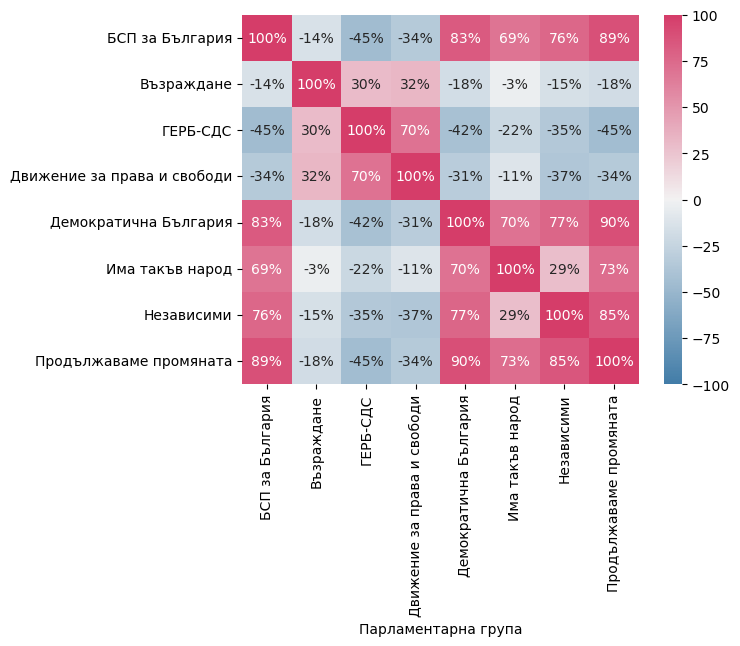

In [9]:
# Annotations
annot = corr.copy() * 100
for col in annot.columns:
    annot[col] = annot[col].map(round).map(lambda x: f'{x}%')
# Coloring
cmap = sb.diverging_palette(240, 0, as_cmap=True)
# Plot
sb.heatmap(corr * 100, cmap=cmap, vmin=-100, vmax=100, annot=annot, fmt='');